In [24]:
import state_space_system
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import numpy as np
from casadi import *

from control.matlab import *
import control 

from ERA import *
from kalman_filter import *
from utils_optimization_problem import *

mpl.rcParams['font.size'] = 16 # set the matplotlib parameter

## 1. System Identification ##

In [25]:
## system identification ##

q = 2   # Number of inputs
p = 3   # Number of outputs
r = 10  # Reduced model order

time = np.linspace(0, 20, num=500)
sys = state_space_system.sys()# import real system
sys.reset()
u = np.zeros((time.shape[0]-1, 2))
u[0,0] = 1
u1 = u

u = np.zeros((time.shape[0]-1, 2))
u[0,1] = 1
u2 = u

re = 10 # repeated time for measurement
y_1 = np.zeros((time.shape[0],3))
y_2 = np.zeros((time.shape[0],3))
for n in range(re):
    y_1_t = sys.simulate(time, u1)
    # Concatenate:
    y_1_t = np.array(y_1_t)
    y_1 += y_1_t

    y_2_t = sys.simulate(time, u2)
    # Concatenate:
    y_2_t = np.array(y_2_t)
    y_2 += y_2_t
y_1 /= re
y_2 /= re
    
yFull = np.zeros((time.shape[0],p,q))

yFull[:,:,0] = y_1[:,:]
yFull[:,:,1] = y_2[:,:]

YY = np.transpose(yFull,axes=(1,2,0)) # reorder to size p x q x m 

# Compute reduced order model from impulse response
mco = int(np.floor((yFull.shape[0]-1)/2)) # m_c = m_o = (m-1)/2
Ar,Br,Cr,Dr,HSVs = ERA(YY,mco,mco,q,p,r)

# simulate the ERA system by using control package
sysERA = ss(Ar,Br,Cr,Dr,1)
y = np.zeros((time.shape[0],p,q))
for qi in range(q):
    y[:,:,qi],t = impulse(sysERA,np.arange(time.shape[0]),input=qi)

Text(0.5, 1.0, 'third mass')

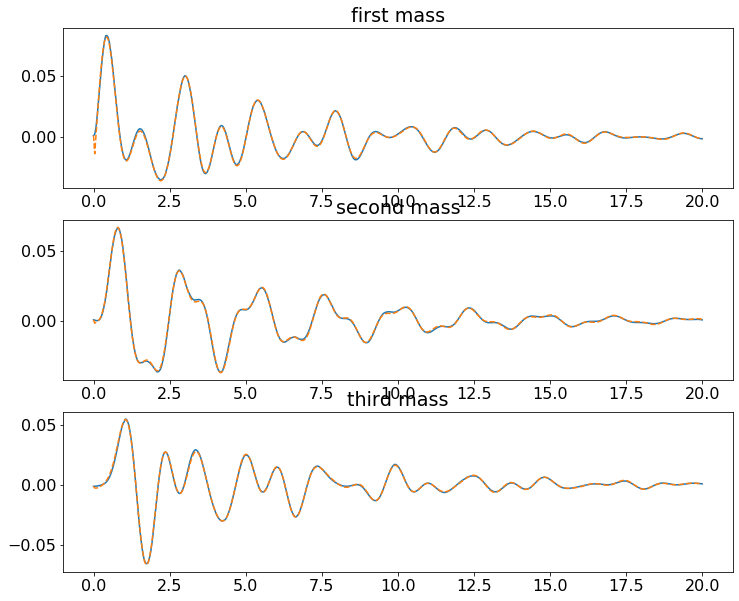

In [26]:
## ident sys. and original sys. ##
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(12,10))
ax1.plot(time, y_1[:,0])
ax1.plot(time, y[:,0,0], '--')
ax1.set_title('first mass')
ax2.plot(time, y_1[:,1])
ax2.plot(time, y[:,1,0], '--')
ax2.set_title('second mass')
ax3.plot(time, y_1[:,2])
ax3.plot(time, y[:,2,0], '--')
ax3.set_title('third mass')

In [27]:
## Augmented system ##
Ab,Bb,Cb = augmented_system(Ar,Br,Cr)

nx = Ab.shape[1] #set the number of state and the control inputs
nu = Bb.shape[1]
ny = Cb.shape[0]

## 2. simutaneous approach ##

In [28]:
## create a symbolic expression of state space ##
x = SX.sym("x",nx,1)
delta_u = SX.sym("delta_u",nu,1)

x_next = Ab@x + Bb@delta_u
system = Function("sys",[x,delta_u],[x_next]) # Create the CasADi function

In [29]:
## MPC initialization and casadi objective function ##

Q = 10                    # make it larger to get a more aggresive controller
Q = Q*np.diag(np.ones(ny)) # the state cost mutiplyer by using the output channel: ny=3

S = Q # S for terminal cost is equal to Q

R = 1                     # set it to 1, trying to reduce the influence from the control energy term
R = np.diag(R*np.ones(nu)) # the cost of control

N = 30                     # horizon

y_Ref = SX.sym("y_ref",ny,1)   # desired trajectory

# state cost
stage_cost = (y_Ref-Cb@x).T@Q@(y_Ref-Cb@x)+ delta_u.T@R@delta_u
stage_cost_fcn = Function('stage_cost',[x,delta_u,y_Ref],[stage_cost])

# terminal cost
terminal_cost = (y_Ref-Cb@x).T@S@(y_Ref-Cb@x)
terminal_cost_fcn = Function('terminal_cost',[x,y_Ref],[terminal_cost])

In [30]:
Q[2,2] = 0
S[2,2] = 0

In [31]:
# state constraints
lb_x = -10*np.ones((nx,1))
ub_x = 10*np.ones((nx,1))
# the last two state variables is actually the control inputs
lb_x[nx-nu:] = -5
ub_x[nx-nu:] = 5
# delta_u changing rate per step constraints
lb_u = -2*np.ones((nu,1))
ub_u = 2*np.ones((nu,1))

In [32]:
## create optimization problem ##
def casadi_setting(nx,nu): # reference_signal:3*15 output*horizon
    
    X = SX.sym("X",(N+1)*nx,1)
    delta_U = SX.sym("U",N*nu,1)
    reference_signal = SX.sym("r",N,ny)

    J = 0
    lb_X = [] # lower bound for X.
    ub_X = [] # upper bound for X
    lb_U = [] # lower bound for delta_U
    ub_U = [] # upper bound for delta_U
    g = []    # constraint expression g
    lb_g = []  # lower bound for constraint expression g
    ub_g = []  # upper bound for constraint expression g
    
    for k in range(N):
        # 01 
        x_k = X[k*nx:(k+1)*nx,:]
        x_k_next = X[(k+1)*nx:(k+2)*nx,:]
        u_k = delta_U[k*nu:(k+1)*nu,:]
        # 01

        # 02 
        # objective
        J += stage_cost_fcn(x_k,u_k,reference_signal[k,:])
        # 02

        # 03 
        # equality constraints (system equation)
        x_k_next_calc = system(x_k,u_k)
        # 03

        # 04
        g.append(x_k_next - x_k_next_calc)
        lb_g.append(np.zeros((nx,1)))
        ub_g.append(np.zeros((nx,1)))
        # 04

        # 05
        lb_X.append(lb_x)
        ub_X.append(ub_x)
        lb_U.append(lb_u)
        ub_U.append(ub_u)
        # 05


    x_terminal = X[N*nx:(N+1)*nx,:]
    J += terminal_cost_fcn(x_terminal,reference_signal[-1,:])
    lb_X.append(lb_x)
    ub_X.append(ub_x)
    return lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J,reference_signal



This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

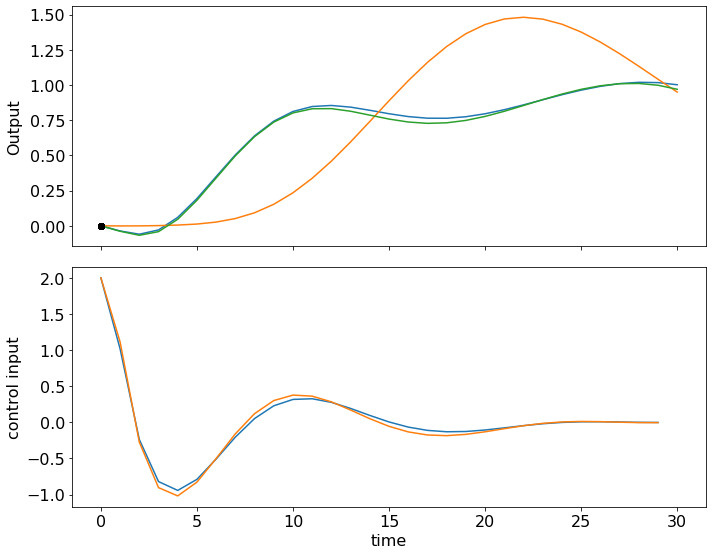

In [41]:
## test the functional solver production ##
reference = np.ones((N,ny))
lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J,param = casadi_setting(nx,nu)
# Casadi solver
lbx = vertcat(*lb_X, *lb_U)
ubx = vertcat(*ub_X, *ub_U)
x = vertcat(X,delta_U)
g = vertcat(*g)
lbg = vertcat(*lb_g)
ubg = vertcat(*ub_g)

prob = {'f':J,'p':param,'x':x,'g':g}
solver = nlpsol('solver','ipopt',prob)

x_0 = np.zeros((nx,1))

lbx[:nx]=x_0
ubx[:nx]=x_0

res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,p=reference)

X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
delta_U = res['x'][(N+1)*nx:].full().reshape(N, nu)
Y = np.zeros((ny,1))

for n in range(N):
    temp = X[n+1].reshape(nx,1)
    Y = np.hstack((Y,Cb@temp))
    

# visulization of the result
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(Y.T)
ax[1].plot(delta_U)
ax[0].set_ylabel('Output')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

# Highlight the selected initial state (the lines should start here!)
ax[0].plot(0,x_0.T, 'o', color='black')

fig.align_ylabels()
fig.tight_layout()

## test result looks pretty good

In [42]:
N_sim = 500 # total simulation step
time = np.linspace(0, 20, num=N_sim)
#################################### compensate for the last time step for 13 units shape:(3, 513)
REFERENCE = np.ones((ny,N_sim+N-1))

# constant tracking
#REFERENCE[:,150:] = 2
#REFERENCE[:,400:] = 1

# trigonometric tracking
REFERENCE[0,:] = np.array(np.sin(np.linspace(-3*np.pi, 3*np.pi, N_sim+N-1))).T
REFERENCE[1,:] = np.array(np.sin(np.linspace(-3*np.pi+2*np.pi/3, 3*np.pi+2*np.pi/3, N_sim+N-1))).T
REFERENCE[2,:] = np.array(np.sin(np.linspace(-3*np.pi+2*2*np.pi/3, 3*np.pi+2*2*np.pi/3, N_sim+N-1))).T
#################################### reference change test

In [43]:
%%time
## MPC main loop ##
x_0 = np.zeros((nx,1))
res_x = [x_0]
res_delta_u = []
res_u = []

## original system measurement initialization
sys.reset()
y_res = [sys.make_measurement()]

## kalman filter parameters
P_k = np.eye(Ab.shape[0],Ab.shape[1])
Q_k = np.ones((Ab.shape[0],Ab.shape[1]))
R_k = np.eye(Cb.shape[0],Cb.shape[0])

X = []

for i in range(N_sim-1):
    
    reference = REFERENCE[:,i:i+N].T
    
    lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J,param = casadi_setting(nx,nu)
    
    # Casadi solver
    lbx = vertcat(*lb_X, *lb_U)
    ubx = vertcat(*ub_X, *ub_U)
    x = vertcat(X,delta_U)
    g = vertcat(*g)
    lbg = vertcat(*lb_g)
    ubg = vertcat(*ub_g)

    if i == 0:
        prob = {'f':J,'p':param,'x':x,'g':g}
        solver = nlpsol('solver','ipopt',prob)
    
    lbx[:nx]=x_0
    ubx[:nx]=x_0
    
    # solving the optimization problem
    res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,p=reference)
    delta_u_k = res['x'][(N+1)*nx:(N+1)*nx+nu,:].full()
    
    X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
    u_st = X[0,10:].reshape(nu,1)+ delta_u_k
    res_u.append(u_st)
    # simulate the system
    sys.simulate(time[i:i+2], (np.array(u_st)).reshape(1,2))
    
    # Append new measurement
    y_res.append(sys.make_measurement())
    
    # state Estimation
    xpred, Ppred = predict(x_0, (np.array(delta_u_k)).reshape(Bb.shape[1],1), P_k, Ab, Q_k, Bb)
    K = K_G(P_k,Cb,R_k)
    x_next,P_k = update(xpred,K,y_res[i+1],Cb,P_k,R_k,Ab)
    
    res_x.append(x_next)
    x_0 = x_next

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   1 7.6427408e+001 1.33e-015 1.89e-001  -1.0 3.51e+000    -  7.38e-001 1.00e+000f  1
   2 6.2238020e+001 1.33e-015 3.19e-002  -1.0 1.11e+000    -  9.37e-001 1.00e+000f  1
   3 6.1666483e+001 1.33e-015 4.64e-003  -1.7 1.18e+000    -  9.58e-001 1.00e+000f  1
   4 6.1636007e+001 2.22e-015 2.92e-015  -2.5 3.54e-001    -  1.00e+000 1.00e+000f  1
   5 6.1635702e+001 2.22e-015 3.09e-015  -3.8 3.65e-002    -  1.00e+000 1.00e+000f  1
   6 6.1635702e+001 1.33e-015 4.82e-015  -5.7 8.74e-004    -  1.00e+000 1.00e+000h  1
   7 6.1635702e+001 1.33e-015 4.45e-015  -8.6 6.80e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  6.1635702026235649e+001   6.1635702026235649e+001
Dual infeasibility......:  4.4489120446732463e-015   4.4489120446732463e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5097633946392857e-009   2.50976339463

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.5015610e+002 3.72e+000 3.43e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.0907772e+002 1.78e-015 2.19e-001  -1.0 3.62e+000    -  7.21e-001 1.00e+000f  1
   2 9.4181300e+001 1.78e-015 5.26e-002  -1.0 9.07e-001    -  8.96e-001 1.00e+000f  1
   3 9.3506252e+001 1.33e-015 4.38e-003  -1.7 1.08e+000    -  9.67e-001 1.00e+000f  1
   4 9.3469047e+001 1.33e-015 3.96e-015  -2.5 3.59e-001    -  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.5331217e+002 3.38e+000 2.04e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.9798774e+002 8.88e-016 1.72e-001  -1.0 3.36e+000    -  7.47e-001 1.00e+000f  1
   2 2.8945741e+002 1.33e-015 2.31e-002  -1.0 1.12e+000    -  9.53e-001 1.00e+000f  1
   3 2.8910349e+002 1.33e-015 4.86e-015  -1.7 7.95e-001    -  1.00e+000 1.00e+000f  1
   4 2.8909452e+002 1.33e-015 5.31e-015  -2.5 1.94e-001    -  1.00e+000 1.00e+000f  1
   5 2.8909449e+002 1.33e-015 7.28e-015  -3.8 1.31e-002    -  1.00e+000 1.00e+000f  1
   6 2.8909449e+002 1.33e-015 7.48e-015  -5.7 3.47e-004    -  1.00e+000 1.00e+000h  1
   7 2.8909449e+002 1.33e-015 5.71e-015  -8.6 3.54e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.8909448555834280e+002   2.8909448555834280e+002
Dual infeasibility......:  5.7082457434814250e-015   

Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.021
Total CPU secs in NLP function evaluations           =      0.002

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  |   1.00ms (125.00us)   1.00ms (125.00us)         8
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms (111.11us)   1.00ms (111.33us)         9
  nlp_hess_l  |        0 (       0)        0 (       0)         7
   nlp_jac_g  |        0 (       0)        0 (       0)         9
       total  |  25.00ms ( 25.00ms)  25.02ms ( 25.02ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linea

   7 3.6946382e+002 1.78e-015 6.97e-015  -8.6 2.53e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.6946382019545973e+002   3.6946382019545973e+002
Dual infeasibility......:  6.9716167454233525e-015   6.9716167454233525e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5068919168684403e-009   2.5068919168684403e-009
Overall NLP error.......:  2.5068919168684403e-009   2.5068919168684403e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   1 4.0572246e+002 8.88e-016 7.70e-002  -1.0 2.15e+000    -  8.21e-001 1.00e+000f  1
   2 4.0082565e+002 1.33e-015 7.83e-015  -1.0 1.08e+000    -  1.00e+000 1.00e+000f  1
   3 4.0072037e+002 8.88e-016 7.17e-015  -1.7 5.94e-001    -  1.00e+000 1.00e+000f  1
   4 4.0071903e+002 8.88e-016 7.10e-015  -2.5 9.57e-002    -  1.00e+000 1.00e+000f  1
   5 4.0071903e+002 1.33e-015 1.31e-014  -3.8 5.53e-003    -  1.00e+000 1.00e+000f  1
   6 4.0071903e+002 2.22e-015 5.10e-015  -5.7 1.86e-004    -  1.00e+000 1.00e+000h  1
   7 4.0071903e+002 8.88e-016 6.61e-015  -8.6 2.10e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.0071902542402290e+002   4.0071902542402290e+002
Dual infeasibility......:  6.6079927274169127e-015   6.6079927274169127e-015
Constraint violation....:  8.8817841970012523e-016   8.8817841970012523e-016
Complementarity.........:  2.5064864508710810e-009   2.50648645087

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.6440965e+002 1.64e+000 2.42e+000  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   4 2.8459467e+002 1.78e-015 7.72e-015  -2.5 1.64e-001    -  1.00e+000 1.00e+000f  1
   5 2.8459465e+002 1.33e-015 1.10e-014  -3.8 1.05e-002    -  1.00e+000 1.00e+000f  1
   6 2.8459465e+002 1.33e-015 9.22e-015  -5.7 3.40e-004    -  1.00e+000 1.00e+000h  1
   7 2.8459465e+002 1.33e-015 6.52e-015  -8.6 3.79e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.8459464797529495e+002   2.8459464797529495e+002
Dual infeasibility......:  6.5187938582634896e-015   6.5187938582634896e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5071039224607584e-009   2.5071039224607584e-009
Overall NLP error.......:  2.5071039224607584e-009   2.5071039224607584e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.6432714e+002 1.46e+000 3.57e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.4451828e+002 1.33e-015 1.38e-001  -1.0 2.98e+000    -  7.69e-001 1.00e+000f  1
   2 2.3429995e+002 1.78e-015 1.92e-002  -1.0 1.03e+000    -  9.53e-001 1.00e+000f  1
   3 2.3399776e+002 1.78e-015 1.35e-003  -1.7 9.05e-001    -  9.83e-001 1.00e+000f  1
   4 2.3398732e+002 2.22e-015 8.12e-015  -2.5 2.19e-001    -  

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.6349448e+002 1.83e+000 3.74e+000  -1.0 0.00e+000    -  0.00e+00

   6 1.4403153e+002 1.33e-015 5.14e-015  -5.7 6.49e-004    -  1.00e+000 1.00e+000h  1
   7 1.4403153e+002 1.33e-015 7.32e-015  -8.6 5.91e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.4403152539828903e+002   1.4403152539828903e+002
Dual infeasibility......:  7.3221609600676303e-015   7.3221609600676303e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5086132645170449e-009   2.5086132645170449e-009
Overall NLP error.......:  2.5086132645170449e-009   2.5086132645170449e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

   3 1.0972545e+002 1.78e-015 3.94e-003  -1.7 1.13e+000    -  9.61e-001 1.00e+000f  1
   4 1.0969984e+002 1.78e-015 3.78e-015  -2.5 3.31e-001    -  1.00e+000 1.00e+000f  1
   5 1.0969962e+002 1.33e-015 3.75e-015  -3.8 3.19e-002    -  1.00e+000 1.00e+000f  1
   6 1.0969962e+002 1.33e-015 3.49e-015  -5.7 7.56e-004    -  1.00e+000 1.00e+000h  1
   7 1.0969962e+002 1.33e-015 2.96e-015  -8.6 6.40e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0969962174472371e+002   1.0969962174472371e+002
Dual infeasibility......:  2.9604857386046109e-015   2.9604857386046109e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5091205556258347e-009   2.5091205556258347e-009
Overall NLP error.......:  2.5091205556258347e-009   2.5091205556258347e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   5 3.9158010e+001 1.78e-015 2.55e-015  -3.8 4.75e-002    -  1.00e+000 1.00e+000f  1
   6 3.9158009e+001 1.33e-015 3.10e-015  -5.7 1.21e-003    -  1.00e+000 1.00e+000f  1
   7 3.9158009e+001 1.33e-015 2.72e-015  -8.6 7.48e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.9158009170290441e+001   3.9158009170290441e+001
Dual infeasibility......:  2.7195780540513611e-015   2.7195780540513611e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5107830853931369e-009   2.5107830853931369e-009
Overall NLP error.......:  2.5107830853931369e-009   2.5107830853931369e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

   4 3.4933298e+001 1.33e-015 3.20e-015  -2.5 4.28e-001    -  1.00e+000 1.00e+000f  1
   5 3.4932673e+001 1.33e-015 2.63e-015  -3.8 5.15e-002    -  1.00e+000 1.00e+000f  1
   6 3.4932673e+001 2.00e-015 4.15e-015  -5.7 1.37e-003    -  1.00e+000 1.00e+000f  1
   7 3.4932673e+001 1.78e-015 3.98e-015  -8.6 7.55e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.4932672961288361e+001   3.4932672961288361e+001
Dual infeasibility......:  3.9821757943217843e-015   3.9821757943217843e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5111903588141715e-009   2.5111903588141715e-009
Overall NLP error.......:  2.5111903588141715e-009   2.5111903588141715e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   2 4.6202993e+001 1.78e-015 5.70e-002  -1.0 1.00e+000    -  8.89e-001 1.00e+000f  1
   3 4.5459418e+001 1.78e-015 7.20e-003  -1.7 1.17e+000    -  9.51e-001 1.00e+000f  1
   4 4.5410037e+001 1.78e-015 3.89e-015  -2.5 4.23e-001    -  1.00e+000 1.00e+000f  1
   5 4.5409418e+001 1.78e-015 4.77e-015  -3.8 5.22e-002    -  1.00e+000 1.00e+000f  1
   6 4.5409418e+001 1.78e-015 3.40e-015  -5.7 1.38e-003    -  1.00e+000 1.00e+000f  1
   7 4.5409418e+001 1.78e-015 3.66e-015  -8.6 7.32e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.5409418065186841e+001   4.5409418065186841e+001
Dual infeasibility......:  3.6609377549822028e-015   3.6609377549822028e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5111384458097958e-009   2.5111384458097958e-009
Overall NLP error.......:  2.5111384458097958e-009   2.5111384458097958e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.5120813e+002 3.45e+000 2.63e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.2706776e+002 1.33e-015 2.06e-001  -1.0 3.36e+000    -  7.28e-001 1.00e+000f  1
   2 2.1624198e+002 1.78e-015 3.82e-002  -1.0 1.06e+000    -  9.22e-001 1.00e+000f  1
   3 2.1574915e+002 1.33e-015 7.27e-015  -1.7 8.65e-001    -  1.00e+000 1.00e+000f  

   2 2.5517541e+002 1.33e-015 2.96e-002  -1.0 1.10e+000    -  9.38e-001 1.00e+000f  1
   3 2.5475362e+002 1.78e-015 7.72e-015  -1.7 8.16e-001    -  1.00e+000 1.00e+000f  1
   4 2.5474048e+002 1.33e-015 5.38e-015  -2.5 2.28e-001    -  1.00e+000 1.00e+000f  1
   5 2.5474041e+002 1.78e-015 7.10e-015  -3.8 1.70e-002    -  1.00e+000 1.00e+000f  1
   6 2.5474041e+002 1.33e-015 8.46e-015  -5.7 4.20e-004    -  1.00e+000 1.00e+000h  1
   7 2.5474041e+002 1.33e-015 6.20e-015  -8.6 4.02e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.5474041379147926e+002   2.5474041379147926e+002
Dual infeasibility......:  6.2015701727587423e-015   6.2015701727587423e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5080851884147630e-009   2.5080851884147630e-009
Overall NLP error.......:  2.5080851884147630e-009   2.5080851884147630e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.5605119e+002 2.70e+000 1.51e+000  -1.0 0.00e+000    -  0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.5817839e+002 2.41e+000 1.08e+000  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   6 3.4780005e+002 1.33e-015 8.20e-015  -5.7 2.18e-004    -  1.00e+000 1.00e+000h  1
   7 3.4780005e+002 1.78e-015 8.62e-015  -8.6 2.53e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.4780004934312973e+002   3.4780004934312973e+002
Dual infeasibility......:  8.6201313520807647e-015   8.6201313520807647e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5067579518659626e-009   2.5067579518659626e-009
Overall NLP error.......:  2.5067579518659626e-009   2.5067579518659626e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

   2 3.1773810e+002 8.88e-016 9.81e-003  -1.0 8.82e-001    -  9.74e-001 1.00e+000f  1
   3 3.1756349e+002 8.88e-016 6.70e-015  -1.7 6.64e-001    -  1.00e+000 1.00e+000f  1
   4 3.1755993e+002 1.33e-015 7.58e-015  -2.5 1.24e-001    -  1.00e+000 1.00e+000f  1
   5 3.1755991e+002 1.33e-015 7.07e-015  -3.8 7.84e-003    -  1.00e+000 1.00e+000f  1
   6 3.1755991e+002 1.78e-015 7.05e-015  -5.7 2.77e-004    -  1.00e+000 1.00e+000h  1
   7 3.1755991e+002 1.33e-015 6.80e-015  -8.6 3.16e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.1755991126818481e+002   3.1755991126818481e+002
Dual infeasibility......:  6.8009565472105561e-015   6.8009565472105561e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5069262233554733e-009   2.5069262233554733e-009
Overall NLP error.......:  2.5069262233554733e-009   2.5069262233554733e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   7 2.1976878e+002 1.33e-015 7.30e-015  -8.6 4.80e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.1976878315982876e+002   2.1976878315982876e+002
Dual infeasibility......:  7.3003643935848334e-015   7.3003643935848334e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5076836868499811e-009   2.5076836868499811e-009
Overall NLP error.......:  2.5076836868499811e-009   2.5076836868499811e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

   3 1.5575879e+002 1.33e-015 2.90e-003  -1.7 1.06e+000    -  9.67e-001 1.00e+000f  1
   4 1.5573939e+002 1.33e-015 9.04e-015  -2.5 2.93e-001    -  1.00e+000 1.00e+000f  1
   5 1.5573926e+002 2.22e-015 6.19e-015  -3.8 2.55e-002    -  1.00e+000 1.00e+000f  1
   6 1.5573926e+002 2.22e-015 4.09e-015  -5.7 6.15e-004    -  1.00e+000 1.00e+000h  1
   7 1.5573926e+002 1.33e-015 3.74e-015  -8.6 5.74e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.5573925513892962e+002   1.5573925513892962e+002
Dual infeasibility......:  3.7449001870463609e-015   3.7449001870463609e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5084496448292744e-009   2.5084496448292744e-009
Overall NLP error.......:  2.5084496448292744e-009   2.5084496448292744e-009


Number of objective function evaluations             = 8
Number of objective gradi

   5 1.0937840e+002 1.33e-015 5.23e-015  -3.8 3.19e-002    -  1.00e+000 1.00e+000f  1
   6 1.0937840e+002 1.78e-015 4.81e-015  -5.7 7.56e-004    -  1.00e+000 1.00e+000h  1
   7 1.0937840e+002 1.78e-015 3.59e-015  -8.6 6.40e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0937840424789857e+002   1.0937840424789857e+002
Dual infeasibility......:  3.5923229775871413e-015   3.5923229775871413e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5091264390768729e-009   2.5091264390768729e-009
Overall NLP error.......:  2.5091264390768729e-009   2.5091264390768729e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

   3 7.1898472e+001 1.55e-015 4.64e-003  -1.7 1.18e+000    -  9.59e-001 1.00e+000f  1
   4 7.1867760e+001 1.78e-015 3.64e-015  -2.5 3.56e-001    -  1.00e+000 1.00e+000f  1
   5 7.1867451e+001 1.78e-015 4.37e-015  -3.8 3.71e-002    -  1.00e+000 1.00e+000f  1
   6 7.1867451e+001 1.78e-015 2.26e-015  -5.7 8.91e-004    -  1.00e+000 1.00e+000h  1
   7 7.1867451e+001 1.33e-015 3.15e-015  -8.6 6.93e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.1867450883078163e+001   7.1867450883078163e+001
Dual infeasibility......:  3.1492436692382223e-015   3.1492436692382223e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5097970033927934e-009   2.5097970033927934e-009
Overall NLP error.......:  2.5097970033927934e-009   2.5097970033927934e-009


Number of objective function evaluations             = 8
Number of objective gradi

   5 4.6520406e+001 1.78e-015 2.34e-015  -3.8 4.47e-002    -  1.00e+000 1.00e+000f  1
   6 4.6520406e+001 1.78e-015 3.34e-015  -5.7 1.09e-003    -  1.00e+000 1.00e+000f  1
   7 4.6520406e+001 1.78e-015 2.39e-015  -8.6 7.34e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.6520406153145650e+001   4.6520406153145650e+001
Dual infeasibility......:  2.3859042475571064e-015   2.3859042475571064e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5104699939597335e-009   2.5104699939597335e-009
Overall NLP error.......:  2.5104699939597335e-009   2.5104699939597335e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   3 3.6456061e+001 1.33e-015 7.47e-003  -1.7 1.19e+000    -  9.49e-001 1.00e+000f  1
   4 3.6407065e+001 1.33e-015 2.96e-015  -2.5 4.28e-001    -  1.00e+000 1.00e+000f  1
   5 3.6406439e+001 1.78e-015 3.39e-015  -3.8 5.17e-002    -  1.00e+000 1.00e+000f  1
   6 3.6406438e+001 1.33e-015 4.77e-015  -5.7 1.37e-003    -  1.00e+000 1.00e+000f  1
   7 3.6406438e+001 1.78e-015 3.43e-015  -8.6 7.50e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.6406438099340761e+001   3.6406438099340761e+001
Dual infeasibility......:  3.4261517892969967e-015   3.4261517892969967e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5111609285408394e-009   2.5111609285408394e-009
Overall NLP error.......:  2.5111609285408394e-009   2.5111609285408394e-009


Number of objective function evaluations             = 8
Number of objective gradi

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.5127573e+002 3.76e+000 3.77e+000  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   5 1.0634459e+002 1.33e-015 3.35e-015  -3.8 4.18e-002    -  1.00e+000 1.00e+000f  1
   6 1.0634459e+002 1.33e-015 8.03e-015  -5.7 9.98e-004    -  1.00e+000 1.00e+000h  1
   7 1.0634459e+002 1.78e-015 5.09e-015  -8.6 6.11e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0634459124750580e+002   1.0634459124750580e+002
Dual infeasibility......:  5.0898966571509720e-015   5.0898966571509720e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5099424660937183e-009   2.5099424660937183e-009
Overall NLP error.......:  2.5099424660937183e-009   2.5099424660937183e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

   5 1.3975939e+002 1.78e-015 4.69e-015  -3.8 3.53e-002    -  1.00e+000 1.00e+000f  1
   6 1.3975939e+002 1.78e-015 6.16e-015  -5.7 8.12e-004    -  1.00e+000 1.00e+000h  1
   7 1.3975939e+002 1.33e-015 4.77e-015  -8.6 5.54e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.3975938929280127e+002   1.3975938929280127e+002
Dual infeasibility......:  4.7656636151890177e-015   4.7656636151890177e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5094195283984253e-009   2.5094195283984253e-009
Overall NLP error.......:  2.5094195283984253e-009   2.5094195283984253e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   7 2.4162136e+002 1.78e-015 8.44e-015  -8.6 4.16e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.4162136471268653e+002   2.4162136471268653e+002
Dual infeasibility......:  8.4431543791940397e-015   8.4431543791940397e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5082014074172021e-009   2.5082014074172021e-009
Overall NLP error.......:  2.5082014074172021e-009   2.5082014074172021e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

   1 3.0041641e+002 8.88e-016 1.67e-001  -1.0 2.96e+000    -  7.52e-001 1.00e+000f  1
   2 2.9202678e+002 1.78e-015 2.03e-002  -1.0 1.13e+000    -  9.55e-001 1.00e+000f  1
   3 2.9168213e+002 1.78e-015 4.66e-015  -1.7 7.88e-001    -  1.00e+000 1.00e+000f  1
   4 2.9167363e+002 1.78e-015 6.27e-015  -2.5 1.89e-001    -  1.00e+000 1.00e+000f  1
   5 2.9167359e+002 1.33e-015 8.58e-015  -3.8 1.29e-002    -  1.00e+000 1.00e+000f  1
   6 2.9167359e+002 1.33e-015 9.29e-015  -5.7 3.44e-004    -  1.00e+000 1.00e+000h  1
   7 2.9167359e+002 1.33e-015 6.06e-015  -8.6 3.53e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.9167359057347647e+002   2.9167359057347647e+002
Dual infeasibility......:  6.0642251038504376e-015   6.0642251038504376e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5077055185265325e-009   2.50770551852

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   2 3.6323330e+002 1.33e-015 6.61e-003  -1.0 1.15e+000    -  9.83e-001 1.00e+000f  1
   3 3.6303747e+002 1.78e-015 6.33e-015  -1.7 7.31e-001    -  1.00e+000 1.00e+000f  1
   4 3.6303417e+002 1.33e-015 7.35e-015  -2.5 1.39e-001    -  1.00e+000 1.00e+000f  1
   5 3.6303415e+002 1.33e-015 6.53e-015  -3.8 8.19e-003    -  1.00e+000 1.00e+000f  1
   6 3.6303415e+002 1.55e-015 6.09e-015  -5.7 2.36e-004    -  1.00e+000 1.00e+000h  1
   7 3.6303415e+002 1.55e-015 6.23e-015  -8.6 2.57e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.6303415423158356e+002   3.6303415423158356e+002
Dual infeasibility......:  6.2311374194996502e-015   6.2311374194996502e-015
Constraint violation....:  1.5543122344752192e-015   1.5543122344752192e-015
Complementarity.........:  2.5069745007435670e-009   2.5069745007435670e-009
Overall NLP error.......:  2.5069745007435670e-009   2.5069745007435670e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   4 3.9860565e+002 1.33e-015 1.19e-014  -2.5 9.52e-002    -  1.00e+000 1.00e+000f  1
   5 3.9860564e+002 1.78e-015 4.59e-015  -3.8 5.56e-003    -  1.00e+000 1.00e+000f  1
   6 3.9860564e+002 8.88e-016 4.98e-015  -5.7 1.89e-004    -  1.00e+000 1.00e+000h  1
   7 3.9860564e+002 8.88e-016 4.95e-015  -8.6 2.14e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.9860564303349162e+002   3.9860564303349162e+002
Dual infeasibility......:  4.9471405829569292e-015   4.9471405829569292e-015
Constraint violation....:  8.8817841970012523e-016   8.8817841970012523e-016
Complementarity.........:  2.5064987183501135e-009   2.5064987183501135e-009
Overall NLP error.......:  2.5064987183501135e-009   2.5064987183501135e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   5 3.8468400e+002 8.88e-016 7.20e-015  -3.8 3.94e-003    -  1.00e+000 1.00e+000f  1
   6 3.8468400e+002 1.33e-015 6.21e-015  -5.7 1.36e-004    -  1.00e+000 1.00e+000h  1
   7 3.8468400e+002 8.88e-016 7.27e-015  -8.6 1.54e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.8468400025081166e+002   3.8468400025081166e+002
Dual infeasibility......:  7.2658486744869475e-015   7.2658486744869475e-015
Constraint violation....:  8.8817841970012523e-016   8.8817841970012523e-016
Complementarity.........:  2.5065120855496462e-009   2.5065120855496462e-009
Overall NLP error.......:  2.5065120855496462e-009   2.5065120855496462e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.6406660e+002 1.60e+000 3.63e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.3041753e+002 1.33e-015 1.42e-001  -1.0 3.02e+000    -  7.66e-001 1.00e+000f  1
   2 2.1978216e+002 1.33e-015 2.04e-002  -1.0 1.05e+000    -  9.51e-001 1.00e+000f  1
   3 2.1945838e+002 1.33e-015 1.65e-003  -1.7 9.36e-001    -  9.80e-001 1.00e+000f  1
   4 2.1944652e+002 1.78e-015 5.01e-015  -2.5 2.33e-001    -  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   3 1.2023477e+002 1.33e-015 3.71e-003  -1.7 1.12e+000    -  9.62e-001 1.00e+000f  1
   4 1.2021064e+002 1.78e-015 4.47e-015  -2.5 3.23e-001    -  1.00e+000 1.00e+000f  1
   5 1.2021044e+002 1.33e-015 3.41e-015  -3.8 3.04e-002    -  1.00e+000 1.00e+000f  1
   6 1.2021044e+002 1.78e-015 4.23e-015  -5.7 7.20e-004    -  1.00e+000 1.00e+000h  1
   7 1.2021044e+002 1.33e-015 4.02e-015  -8.6 6.25e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.2021043925395762e+002   1.2021043925395762e+002
Dual infeasibility......:  4.0190203510988070e-015   4.0190203510988070e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5089393964946671e-009   2.5089393964946671e-009
Overall NLP error.......:  2.5089393964946671e-009   2.5089393964946671e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.5189446e+002 3.71e+000 3.85e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 5.8511720e+001 2.22e-015 2.28e-001  -1.0 3.62e+000    -  7.16e-001 1.00e+000f  1
   2 4.2092895e+001 1.78e-015 5.69e-002  -1.0 1.02e+000    -  8.89e-001 1.00e+000f  1
   3 4.1351395e+001 1.33e-015 7.38e-003  -1.7 1.18e+000    -  9.50e-001 1.00e+000f  

   6 6.2452070e+001 1.78e-015 4.70e-015  -5.7 1.28e-003    -  1.00e+000 1.00e+000f  1
   7 6.2452070e+001 1.33e-015 3.95e-015  -8.6 6.95e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  6.2452069695531470e+001   6.2452069695531470e+001
Dual infeasibility......:  3.9532202906572512e-015   3.9532202906572512e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5107824499841217e-009   2.5107824499841217e-009
Overall NLP error.......:  2.5107824499841217e-009   2.5107824499841217e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.5011558e+002 3.78e+000 3.43e+000  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   6 1.7669706e+002 1.33e-015 5.80e-015  -5.7 6.39e-004    -  1.00e+000 1.00e+000h  1
   7 1.7669706e+002 1.33e-015 6.87e-015  -8.6 4.94e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.7669705756714097e+002   1.7669705756714097e+002
Dual infeasibility......:  6.8729047698299776e-015   6.8729047698299776e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5089137827723674e-009   2.5089137827723674e-009
Overall NLP error.......:  2.5089137827723674e-009   2.5089137827723674e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.5156315e+002 3.38e+000 2.54e+000  -1.0 0.00e+000    -  0.00e+00

   4 2.6719183e+002 8.88e-016 1.02e-014  -2.5 2.11e-001    -  1.00e+000 1.00e+000f  1
   5 2.6719178e+002 1.78e-015 7.05e-015  -3.8 1.54e-002    -  1.00e+000 1.00e+000f  1
   6 2.6719178e+002 1.11e-015 5.89e-015  -5.7 3.91e-004    -  1.00e+000 1.00e+000h  1
   7 2.6719178e+002 1.78e-015 5.13e-015  -8.6 3.85e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.6719178158177186e+002   2.6719178158177186e+002
Dual infeasibility......:  5.1323678949779275e-015   5.1323678949779275e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5079510677612582e-009   2.5079510677612582e-009
Overall NLP error.......:  2.5079510677612582e-009   2.5079510677612582e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   2 3.5469135e+002 1.33e-015 9.44e-003  -1.0 1.15e+000    -  9.77e-001 1.00e+000f  1
   3 3.5447731e+002 1.78e-015 8.48e-015  -1.7 7.39e-001    -  1.00e+000 1.00e+000f  1
   4 3.5447341e+002 1.78e-015 9.25e-015  -2.5 1.48e-001    -  1.00e+000 1.00e+000f  1
   5 3.5447339e+002 1.33e-015 6.51e-015  -3.8 8.73e-003    -  1.00e+000 1.00e+000f  1
   6 3.5447339e+002 1.33e-015 7.90e-015  -5.7 2.42e-004    -  1.00e+000 1.00e+000h  1
   7 3.5447339e+002 1.78e-015 9.66e-015  -8.6 2.61e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.5447339134556836e+002   3.5447339134556836e+002
Dual infeasibility......:  9.6550757793565734e-015   9.6550757793565734e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5070668837128948e-009   2.5070668837128948e-009
Overall NLP error.......:  2.5070668837128948e-009   2.5070668837128948e-00

   3 3.8313930e+002 1.33e-015 5.16e-015  -1.7 6.79e-001    -  1.00e+000 1.00e+000f  1
   4 3.8313732e+002 1.33e-015 1.01e-014  -2.5 1.12e-001    -  1.00e+000 1.00e+000f  1
   5 3.8313731e+002 1.33e-015 6.83e-015  -3.8 6.67e-003    -  1.00e+000 1.00e+000f  1
   6 3.8313731e+002 2.22e-015 5.32e-015  -5.7 2.14e-004    -  1.00e+000 1.00e+000h  1
   7 3.8313731e+002 1.11e-015 7.15e-015  -8.6 2.39e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.8313730853694295e+002   3.8313730853694295e+002
Dual infeasibility......:  7.1482001126874003e-015   7.1482001126874003e-015
Constraint violation....:  1.1102230246251565e-015   1.1102230246251565e-015
Complementarity.........:  2.5067010972261834e-009   2.5067010972261834e-009
Overall NLP error.......:  2.5067010972261834e-009   2.5067010972261834e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.6474611e+002 1.48e+000 2.61e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.7137482e+002 1.11e-015 8.09e-002  -1.0 2.21e+000    -  8.17e-001 1.00e+000f  1
   2 3.6544333e+002 8.88e-016 1.16e-003  -1.0 7.95e-001    -  9.96e-001 1.00e+000f  1
   3 3.6532918e+002 8.88e-016 8.96e-015  -1.7 4.58e-001    -  1.00e+000 1.00e+000f  1
   4 3.6532777e+002 1.33e-015 6.93e-015  -2.5 7.00e-002    -  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.6491846e+002 1.35e+000 3.38e+000  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   1 1.4543982e+002 1.33e-015 1.60e-001  -1.0 3.24e+000    -  7.54e-001 1.00e+000f  1
   2 1.3195803e+002 1.78e-015 2.60e-002  -1.0 1.14e+000    -  9.40e-001 1.00e+000f  1
   3 1.3148465e+002 2.22e-015 3.46e-003  -1.7 1.10e+000    -  9.64e-001 1.00e+000f  1
   4 1.3146204e+002 1.78e-015 5.47e-015  -2.5 3.14e-001    -  1.00e+000 1.00e+000f  1
   5 1.3146186e+002 1.78e-015 5.70e-015  -3.8 2.88e-002    -  1.00e+000 1.00e+000f  1
   6 1.3146186e+002 1.33e-015 3.93e-015  -5.7 6.85e-004    -  1.00e+000 1.00e+000h  1
   7 1.3146186e+002 1.78e-015 4.00e-015  -8.6 6.09e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.3146185758596098e+002   1.3146185758596098e+002
Dual infeasibility......:  4.0023066440440260e-015   4.0023066440440260e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5087826773696099e-009   2.50878267736

   7 9.8978505e+001 1.78e-015 3.01e-015  -8.6 6.55e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.8978504876342569e+001   9.8978504876342569e+001
Dual infeasibility......:  3.0148282225966742e-015   3.0148282225966742e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5092864577143259e-009   2.5092864577143259e-009
Overall NLP error.......:  2.5092864577143259e-009   2.5092864577143259e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

   4 7.2001520e+001 1.78e-015 2.46e-015  -2.5 3.56e-001    -  1.00e+000 1.00e+000f  1
   5 7.2001212e+001 1.33e-015 3.38e-015  -3.8 3.70e-002    -  1.00e+000 1.00e+000f  1
   6 7.2001212e+001 1.33e-015 5.52e-015  -5.7 8.89e-004    -  1.00e+000 1.00e+000h  1
   7 7.2001212e+001 1.33e-015 4.38e-015  -8.6 6.93e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.2001212313609656e+001   7.2001212313609656e+001
Dual infeasibility......:  4.3836592733947352e-015   4.3836592733947352e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5097786941407571e-009   2.5097786941407571e-009
Overall NLP error.......:  2.5097786941407571e-009   2.5097786941407571e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   1 6.3584112e+001 1.33e-015 1.86e-001  -1.0 3.24e+000    -  7.40e-001 1.00e+000f  1
   2 4.7332868e+001 1.78e-015 4.10e-002  -1.0 1.15e+000    -  9.15e-001 1.00e+000f  1
   3 4.6680039e+001 2.00e-015 6.31e-003  -1.7 1.20e+000    -  9.52e-001 1.00e+000f  1
   4 4.6640439e+001 1.78e-015 2.66e-015  -2.5 3.97e-001    -  1.00e+000 1.00e+000f  1
   5 4.6639977e+001 1.55e-015 4.02e-015  -3.8 4.45e-002    -  1.00e+000 1.00e+000f  1
   6 4.6639976e+001 1.78e-015 3.35e-015  -5.7 1.08e-003    -  1.00e+000 1.00e+000f  1
   7 4.6639976e+001 1.33e-015 4.51e-015  -8.6 7.33e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.6639976468286747e+001   4.6639976468286747e+001
Dual infeasibility......:  4.5077265185196775e-015   4.5077265185196775e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5104659349886946e-009   2.51046593498

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   1 7.2718820e+001 1.33e-015 2.34e-001  -1.0 3.68e+000    -  7.13e-001 1.00e+000f  1
   2 5.6779052e+001 1.78e-015 5.84e-002  -1.0 9.63e-001    -  8.87e-001 1.00e+000f  1
   3 5.6044386e+001 1.33e-015 6.79e-003  -1.7 1.15e+000    -  9.54e-001 1.00e+000f  1
   4 5.5996284e+001 1.78e-015 3.44e-015  -2.5 4.14e-001    -  1.00e+000 1.00e+000f  1
   5 5.5995708e+001 1.33e-015 3.30e-015  -3.8 5.08e-002    -  1.00e+000 1.00e+000f  1
   6 5.5995707e+001 1.33e-015 3.33e-015  -5.7 1.32e-003    -  1.00e+000 1.00e+000f  1
   7 5.5995707e+001 1.33e-015 3.56e-015  -8.6 7.08e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  5.5995707394523308e+001   5.5995707394523308e+001
Dual infeasibility......:  3.5635213692212126e-015   3.5635213692212126e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5109049551450767e-009   2.51090495514

   1 9.3958601e+001 1.78e-015 2.36e-001  -1.0 3.70e+000    -  7.12e-001 1.00e+000f  1
   2 7.8713333e+001 2.00e-015 5.81e-002  -1.0 9.00e-001    -  8.88e-001 1.00e+000f  1
   3 7.8000781e+001 1.33e-015 5.83e-003  -1.7 1.11e+000    -  9.59e-001 1.00e+000f  1
   4 7.7956460e+001 1.33e-015 4.98e-015  -2.5 3.90e-001    -  1.00e+000 1.00e+000f  1
   5 7.7955977e+001 1.78e-015 3.80e-015  -3.8 4.70e-002    -  1.00e+000 1.00e+000f  1
   6 7.7955976e+001 1.78e-015 3.99e-015  -5.7 1.17e-003    -  1.00e+000 1.00e+000f  1
   7 7.7955976e+001 2.22e-015 5.70e-015  -8.6 6.63e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.7955976262955531e+001   7.7955976262955531e+001
Dual infeasibility......:  5.7012119554176457e-015   5.7012119554176457e-015
Constraint violation....:  2.2204460492503131e-015   2.2204460492503131e-015
Complementarity.........:  2.5104522077074733e-009   2.51045220770

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.5004192e+002 3.75e+000 3.30e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.3164811e+002 1.78e-015 2.33e-001  -1.0 3.66e+000    -  7.14e-001 1.00e+000f  1
   2 1.1764058e+002 1.33e-015 5.47e-002  -1.0 9.31e-001    -  8.93e-001 1.00e+000f  1
   3 1.1698028e+002 1.78e-015 4.06e-003  -1.7 1.05e+000    -  9.69e-001 1.00e+000f  1
   4 1.1694337e+002 1.33e-015 5.45e-015  -2.5 3.62e-001    -  

   2 1.5235537e+002 1.33e-015 5.00e-002  -1.0 9.90e-001    -  9.01e-001 1.00e+000f  1
   3 1.5175009e+002 1.33e-015 2.40e-003  -1.7 9.82e-001    -  9.80e-001 1.00e+000f  1
   4 1.5171991e+002 1.33e-015 7.80e-015  -2.5 3.35e-001    -  1.00e+000 1.00e+000f  1
   5 1.5171969e+002 1.78e-015 8.98e-015  -3.8 3.28e-002    -  1.00e+000 1.00e+000f  1
   6 1.5171969e+002 1.78e-015 3.97e-015  -5.7 7.49e-004    -  1.00e+000 1.00e+000h  1
   7 1.5171969e+002 1.33e-015 9.09e-015  -8.6 5.34e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.5171968502686192e+002   1.5171968502686192e+002
Dual infeasibility......:  9.0927792306595717e-015   9.0927792306595717e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5092420490978935e-009   2.5092420490978935e-009
Overall NLP error.......:  2.5092420490978935e-009   2.5092420490978935e-00

   5 2.0250087e+002 1.33e-015 7.44e-015  -3.8 2.35e-002    -  1.00e+000 1.00e+000f  1
   6 2.0250087e+002 1.33e-015 6.90e-015  -5.7 5.48e-004    -  1.00e+000 1.00e+000h  1
   7 2.0250087e+002 1.78e-015 5.95e-015  -8.6 4.63e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.0250087294732612e+002   2.0250087294732612e+002
Dual infeasibility......:  5.9477570148117872e-015   5.9477570148117872e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5086241483923394e-009   2.5086241483923394e-009
Overall NLP error.......:  2.5086241483923394e-009   2.5086241483923394e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   5 3.5438534e+002 1.33e-015 7.83e-015  -3.8 8.65e-003    -  1.00e+000 1.00e+000f  1
   6 3.5438534e+002 1.33e-015 6.38e-015  -5.7 2.40e-004    -  1.00e+000 1.00e+000h  1
   7 3.5438534e+002 1.78e-015 6.70e-015  -8.6 2.59e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.5438534301598270e+002   3.5438534301598270e+002
Dual infeasibility......:  6.6950095073493106e-015   6.6950095073493106e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5070626022148586e-009   2.5070626022148586e-009
Overall NLP error.......:  2.5070626022148586e-009   2.5070626022148586e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.5866860e+002 2.31e+000 1.03e+000  -1.0 0.00e+000    -  0.00e+00

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.6020809e+002 2.05e+000 1.35e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 4.0102217e+002 8.88e-016 7.11e-002  -1.0 2.04e+000    -  8.29e-001 1.00e+000f  1
   2 3.9603533e+002 8.88e-016 6.49e-015  -1.0 1.13e+000    -  1.00e+000 1.00e+000f  1
   3 3.9592666e+002 8.88e-016 7.62e-015  -1.7 6.11e-001    -  1.00e+000 1.00e+000f  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   5 3.9012624e+002 1.78e-015 5.95e-015  -3.8 4.13e-003    -  1.00e+000 1.00e+000f  1
   6 3.9012624e+002 1.33e-015 9.62e-015  -5.7 1.44e-004    -  1.00e+000 1.00e+000h  1
   7 3.9012624e+002 1.33e-015 7.34e-015  -8.6 1.63e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.9012623669764196e+002   3.9012623669764196e+002
Dual infeasibility......:  7.3392438940780754e-015   7.3392438940780754e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5064664402856662e-009   2.5064664402856662e-009
Overall NLP error.......:  2.5064664402856662e-009   2.5064664402856662e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   2 3.3915858e+002 1.33e-015 6.53e-003  -1.0 8.24e-001    -  9.82e-001 1.00e+000f  1
   3 3.3901123e+002 8.88e-016 9.69e-015  -1.7 5.84e-001    -  1.00e+000 1.00e+000f  1
   4 3.3900875e+002 1.33e-015 5.94e-015  -2.5 9.86e-002    -  1.00e+000 1.00e+000f  1
   5 3.3900874e+002 1.33e-015 8.02e-015  -3.8 6.33e-003    -  1.00e+000 1.00e+000f  1
   6 3.3900874e+002 8.88e-016 8.82e-015  -5.7 2.38e-004    -  1.00e+000 1.00e+000h  1
   7 3.3900874e+002 1.33e-015 8.70e-015  -8.6 2.74e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.3900874247491612e+002   3.3900874247491612e+002
Dual infeasibility......:  8.7048974331234099e-015   8.7048974331234099e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5068169577601632e-009   2.5068169577601632e-009
Overall NLP error.......:  2.5068169577601632e-009   2.5068169577601632e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.6493575e+002 1.35e+000 3.38e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.8003423e+002 8.88e-016 1.26e-001  -1.0 2.83e+000    -  7.78e-001 1.00e+000f  1
   2 2.7106868e+002 1.33e-015 1.57e-002  -1.0 9.77e-001    -  9.60e-001 1.00e+000f  1
   3 2.7082541e+002 1.78e-015 3.82e-004  -1.7 8.11e-001    -  9.95e-001 1.00e+000f  1
   4 2.7081846e+002 1.33e-015 7.89e-015  -2.5 1.78e-001    -  

   1 2.4290222e+002 1.33e-015 1.38e-001  -1.0 2.98e+000    -  7.69e-001 1.00e+000f  1
   2 2.3269536e+002 8.88e-016 1.93e-002  -1.0 1.04e+000    -  9.53e-001 1.00e+000f  1
   3 2.3239254e+002 1.33e-015 1.36e-003  -1.7 9.07e-001    -  9.83e-001 1.00e+000f  1
   4 2.3238203e+002 1.33e-015 6.15e-015  -2.5 2.19e-001    -  1.00e+000 1.00e+000f  1
   5 2.3238198e+002 1.33e-015 8.28e-015  -3.8 1.58e-002    -  1.00e+000 1.00e+000f  1
   6 2.3238198e+002 1.33e-015 8.04e-015  -5.7 4.37e-004    -  1.00e+000 1.00e+000h  1
   7 2.3238198e+002 8.88e-016 5.36e-015  -8.6 4.61e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.3238197650691734e+002   2.3238197650691734e+002
Dual infeasibility......:  5.3605281571914736e-015   5.3605281571914736e-015
Constraint violation....:  8.8817841970012523e-016   8.8817841970012523e-016
Complementarity.........:  2.5075565323599624e-009   2.50755653235

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   2 1.4377848e+002 1.33e-015 2.54e-002  -1.0 1.13e+000    -  9.41e-001 1.00e+000f  1
   3 1.4332612e+002 1.33e-015 3.19e-003  -1.7 1.08e+000    -  9.65e-001 1.00e+000f  1
   4 1.4330509e+002 1.33e-015 5.09e-015  -2.5 3.04e-001    -  1.00e+000 1.00e+000f  1
   5 1.4330494e+002 1.33e-015 7.49e-015  -3.8 2.72e-002    -  1.00e+000 1.00e+000f  1
   6 1.4330494e+002 1.78e-015 3.30e-015  -5.7 6.50e-004    -  1.00e+000 1.00e+000h  1
   7 1.4330494e+002 1.33e-015 5.18e-015  -8.6 5.92e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.4330493532883040e+002   1.4330493532883040e+002
Dual infeasibility......:  5.1778620345749559e-015   5.1778620345749559e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5086093683168740e-009   2.5086093683168740e-009
Overall NLP error.......:  2.5086093683168740e-009   2.5086093683168740e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   3 6.4577099e+001 1.78e-015 5.07e-003  -1.7 1.18e+000    -  9.57e-001 1.00e+000f  1
   4 6.4544288e+001 1.78e-015 4.42e-015  -2.5 3.67e-001    -  1.00e+000 1.00e+000f  1
   5 6.4543945e+001 2.22e-015 3.46e-015  -3.8 3.89e-002    -  1.00e+000 1.00e+000f  1
   6 6.4543945e+001 1.11e-015 3.07e-015  -5.7 9.34e-004    -  1.00e+000 1.00e+000h  1
   7 6.4543945e+001 1.33e-015 3.74e-015  -8.6 7.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  6.4543944666193525e+001   6.4543944666193525e+001
Dual infeasibility......:  3.7437088616758274e-015   3.7437088616758274e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5099518726037163e-009   2.5099518726037163e-009
Overall NLP error.......:  2.5099518726037163e-009   2.5099518726037163e-009


Number of objective function evaluations             = 8
Number of objective gradi

   6 4.6597140e+001 1.33e-015 6.49e-015  -5.7 1.09e-003    -  1.00e+000 1.00e+000f  1
   7 4.6597140e+001 1.78e-015 6.01e-015  -8.6 7.33e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.6597140491002676e+001   4.6597140491002676e+001
Dual infeasibility......:  6.0145883113968456e-015   6.0145883113968456e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5104737729161206e-009   2.5104737729161206e-009
Overall NLP error.......:  2.5104737729161206e-009   2.5104737729161206e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

   4 3.6512230e+001 1.33e-015 3.31e-015  -2.5 4.18e-001    -  1.00e+000 1.00e+000f  1
   5 3.6511664e+001 1.78e-015 3.91e-015  -3.8 4.85e-002    -  1.00e+000 1.00e+000f  1
   6 3.6511664e+001 1.78e-015 5.21e-015  -5.7 1.26e-003    -  1.00e+000 1.00e+000f  1
   7 3.6511664e+001 1.78e-015 3.39e-015  -8.6 7.51e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.6511664028303969e+001   3.6511664028303969e+001
Dual infeasibility......:  3.3852511623124875e-015   3.3852511623124875e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5109208133159813e-009   2.5109208133159813e-009
Overall NLP error.......:  2.5109208133159813e-009   2.5109208133159813e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   3 3.6071111e+001 1.33e-015 7.50e-003  -1.7 1.19e+000    -  9.49e-001 1.00e+000f  1
   4 3.6021769e+001 1.78e-015 3.02e-015  -2.5 4.29e-001    -  1.00e+000 1.00e+000f  1
   5 3.6021134e+001 1.55e-015 2.21e-015  -3.8 5.22e-002    -  1.00e+000 1.00e+000f  1
   6 3.6021133e+001 1.33e-015 2.71e-015  -5.7 1.39e-003    -  1.00e+000 1.00e+000f  1
   7 3.6021133e+001 1.33e-015 3.00e-015  -8.6 7.51e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.6021133168149895e+001   3.6021133168149895e+001
Dual infeasibility......:  2.9984589932536296e-015   2.9984589932536296e-015
Constraint violation....:  1.3322676295501878e-015   1.3322676295501878e-015
Complementarity.........:  2.5112153343766503e-009   2.5112153343766503e-009
Overall NLP error.......:  2.5112153343766503e-009   2.5112153343766503e-009


Number of objective function evaluations             = 8
Number of objective gradi

   7 4.5353103e+001 1.78e-015 3.87e-015  -8.6 7.31e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.5353103191432176e+001   4.5353103191432176e+001
Dual infeasibility......:  3.8720707756015858e-015   3.8720707756015858e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5111131426372722e-009   2.5111131426372722e-009
Overall NLP error.......:  2.5111131426372722e-009   2.5111131426372722e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

   3 6.2578303e+001 1.78e-015 6.52e-003  -1.7 1.14e+000    -  9.55e-001 1.00e+000f  1
   4 6.2531232e+001 1.78e-015 2.91e-015  -2.5 4.07e-001    -  1.00e+000 1.00e+000f  1
   5 6.2530683e+001 1.33e-015 3.57e-015  -3.8 4.97e-002    -  1.00e+000 1.00e+000f  1
   6 6.2530683e+001 1.33e-015 2.57e-015  -5.7 1.28e-003    -  1.00e+000 1.00e+000f  1
   7 6.2530683e+001 1.78e-015 3.45e-015  -8.6 6.94e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  6.2530683116020469e+001   6.2530683116020469e+001
Dual infeasibility......:  3.4534219091547305e-015   3.4534219091547305e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5107651319326711e-009   2.5107651319326711e-009
Overall NLP error.......:  2.5107651319326711e-009   2.5107651319326711e-009


Number of objective function evaluations             = 8
Number of objective gradi

   1 1.0247224e+002 1.33e-015 2.35e-001  -1.0 3.70e+000    -  7.13e-001 1.00e+000f  1
   2 8.7508309e+001 1.78e-015 5.76e-002  -1.0 8.78e-001    -  8.89e-001 1.00e+000f  1
   3 8.6807532e+001 1.78e-015 5.43e-003  -1.7 1.10e+000    -  9.61e-001 1.00e+000f  1
   4 8.6764917e+001 1.78e-015 5.50e-015  -2.5 3.80e-001    -  1.00e+000 1.00e+000f  1
   5 8.6764471e+001 1.78e-015 5.51e-015  -3.8 4.53e-002    -  1.00e+000 1.00e+000f  1
   6 8.6764471e+001 1.33e-015 6.34e-015  -5.7 1.11e-003    -  1.00e+000 1.00e+000h  1
   7 8.6764471e+001 1.78e-015 8.50e-015  -8.6 6.46e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  8.6764471095774809e+001   8.6764471095774809e+001
Dual infeasibility......:  8.5020852671311591e-015   8.5020852671311591e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5102745626132268e-009   2.51027456261

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   2 2.9212434e+002 1.33e-015 2.05e-002  -1.0 1.13e+000    -  9.55e-001 1.00e+000f  1
   3 2.9177735e+002 1.33e-015 7.10e-015  -1.7 7.91e-001    -  1.00e+000 1.00e+000f  1
   4 2.9176874e+002 1.78e-015 7.88e-015  -2.5 1.90e-001    -  1.00e+000 1.00e+000f  1
   5 2.9176871e+002 1.33e-015 7.39e-015  -3.8 1.29e-002    -  1.00e+000 1.00e+000f  1
   6 2.9176871e+002 1.33e-015 9.87e-015  -5.7 3.45e-004    -  1.00e+000 1.00e+000h  1
   7 2.9176871e+002 1.55e-015 5.17e-015  -8.6 3.54e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.9176870577132229e+002   2.9176870577132229e+002
Dual infeasibility......:  5.1722466561209132e-015   5.1722466561209132e-015
Constraint violation....:  1.5543122344752192e-015   1.5543122344752192e-015
Complementarity.........:  2.5077111588472891e-009   2.5077111588472891e-009
Overall NLP error.......:  2.5077111588472891e-009   2.5077111588472891e-00


                                   (scaled)                 (unscaled)
Objective...............:  3.3587296067869698e+002   3.3587296067869698e+002
Dual infeasibility......:  8.3189591262149436e-015   8.3189591262149436e-015
Constraint violation....:  8.8817841970012523e-016   8.8817841970012523e-016
Complementarity.........:  2.5072668814836087e-009   2.5072668814836087e-009
Overall NLP error.......:  2.5072668814836087e-009   2.5072668814836087e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.021
Total CPU secs in NLP function evaluations           =      0.001

EXIT: Opt

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.6027027e+002 2.05e+000 1.35e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 4.0101085e+002 6.66e-016 7.11e-002  -1.0 2.04e+000    -  8.29e-001 1.00e+000f  1
   2 3.9602367e+002 8.88e-016 7.36e-015  -1.0 1.13e+000    -  1.00e+000 1.00e+000f  1
   3 3.9591532e+002 8.88e-016 7.03e-015  -1.7 6.10e-001    -  1.00e+000 1.00e+000f  1
   4 3.9591385e+002 8.88e-016 7.16e-015  -2.5 9.95e-002    -  

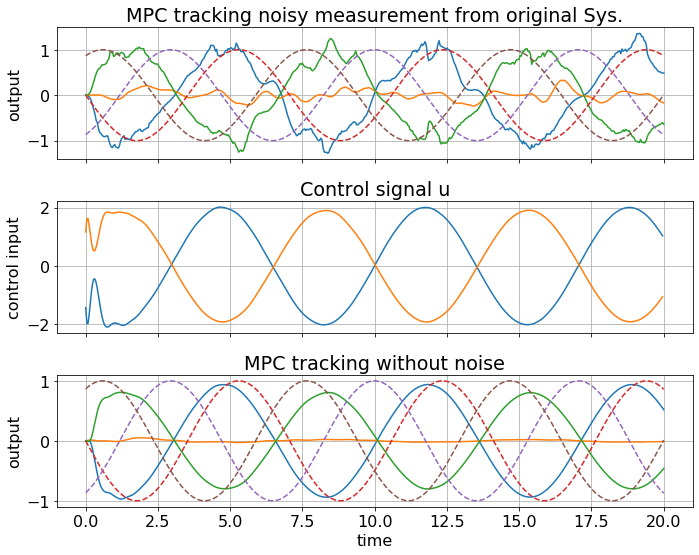

In [44]:
## results visualization ##


res_x_T = np.concatenate(res_x,axis=1)
res_u = np.array(res_u)
res_u = res_u.reshape(time.shape[0]-1,nu)

res_y = np.array(y_res)

y0 = np.zeros((ny,1))
res_y_withoutnoise = [y0]
for n in range(len(time)-1):
    temp = (Cb@res_x_T[:,n]).reshape(Cb.shape[0],1) + (Dr@res_u[n,:]).reshape(Cb.shape[0],1)
    res_y_withoutnoise.append(temp)
res_y_withoutnoise = np.array(res_y_withoutnoise).reshape(len(time),Cb.shape[0])


fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].plot(time,res_y)
ax[0].plot(time,REFERENCE.T[:N_sim], '--')
ax[0].set_title('MPC tracking noisy measurement from original Sys.')
ax[0].set_ylabel('output')
ax[0].grid()

ax[1].set_title('Control signal u')
ax[1].plot(time[:-1],res_u)
ax[1].set_ylabel('control input')
ax[1].grid()

ax[2].plot(time,res_y_withoutnoise)
ax[2].plot(time,REFERENCE.T[:N_sim], '--')
ax[2].set_title('MPC tracking without noise')
ax[2].set_xlabel('time')
ax[2].set_ylabel('output')
ax[2].grid()

fig.align_ylabels()
fig.tight_layout()

plt.savefig('constant',dpi=250)